In [42]:
from random import random
import numpy as np
import mpmath as mp
import trace_gen as tg # source code at: https://github.com/Effygal/trace-gen
import matplotlib.pyplot as plt
from sympy import symbols, exp, laplace_transform, inverse_laplace_transform, solve
from scipy.integrate import quad
from scipy.optimize import root_scalar
import heapq
import torch
import seaborn as sns
import pandas as pd
import itertools
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['text.usetex']  = False
palette = sns.color_palette("deep", n_colors=13)
np.random.seed(77)

In [27]:
def gen_from_zipf(M, n, a):
    p = 1.0 / np.power(np.arange(1, M + 1), a)
    p = p / p.sum()
    return p, np.random.choice(M, size=n, p=p)

def gen_from_he(m, a, n):
    p = 1.0 / np.power(np.arange(1, m + 1), a)
    p = p / p.sum()
    cp = np.cumsum(p)
    t = p.copy()
    phases = np.searchsorted(cp, np.random.random(m), side="right")
    next_times = np.random.exponential(1.0 / t[phases])
    heap = [(next_times[i], i) for i in range(m)]
    heapq.heapify(heap)
    trace = np.empty(n, dtype=np.int32)
    for idx in range(n):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = np.searchsorted(cp, np.random.random(), side="right")
        next_time = ctime + np.random.exponential(1.0 / t[phases[item]])
        heapq.heappush(heap, (next_time, item))
    return trace

def gen_from_ph(alphas, Ts, length): # slower than gen_from_2ph, but general
    A = np.asarray(alphas, np.float64)
    T = np.asarray(Ts, np.float64)
    n, m = A.shape
    A = A / A.sum(axis=1, keepdims=True)
    A_cdf = np.cumsum(A, axis=1)
    A_cdf[:, -1] = 1.0
    one = np.ones(m, np.float64)
    mu = -(T @ one)
    off = T.copy()
    idx = np.arange(m)
    off[:, idx, idx] = 0.0
    rdiag = -np.diagonal(T, axis1=1, axis2=2)
    jump = np.concatenate((off, mu[..., None]), axis=2) / rdiag[..., None]
    jump_cdf = np.cumsum(jump, axis=2)
    jump_cdf[:, :, -1] = 1.0
    def ph_time(k):
        s = np.searchsorted(A_cdf[k], np.random.random(), side="right")
        t = 0.0
        while 1:
            rate = rdiag[k, s]
            t += np.random.exponential(1.0 / rate)
            nxt = np.searchsorted(jump_cdf[k, s], np.random.random(), side="right")
            if nxt == m: return t
            s = nxt
    h = [(ph_time(i), i) for i in range(n)]
    heapq.heapify(h)
    trc = np.empty(length, np.int32)
    for t_idx in range(length):
        ct, i = h[0]
        trc[t_idx] = i + 1
        heapq.heapreplace(h, (ct + ph_time(i), i))
    return trc

def gen_from_2ph(n, theta, length, mu_ratio=10.0):
    n = int(n)
    length = int(length)
    p = np.arange(1, n + 1, dtype=np.float64)
    p = np.power(p, -float(theta))
    p /= p.sum()
    mr = float(mu_ratio)
    t0 = 0.5 * (mr + 1.0)
    t1 = 0.5 * (1.0 + 1.0 / mr)
    inv_rate0 = 1.0 / (t0 * p)
    inv_rate1 = 1.0 / (t1 * p)
    init_phase1 = (np.random.random(n) >= 0.5)
    init_scales = np.where(init_phase1, inv_rate1, inv_rate0)
    next_times = np.random.exponential(init_scales)
    heap = [(next_times[i], i) for i in range(n)]
    heapq.heapify(heap)
    trace = np.empty(length, dtype=np.int32)
    rand = np.random.random
    exp = np.random.exponential
    hreplace = heapq.heapreplace
    for idx in range(length):
        ctime, item = heap[0]
        trace[idx] = item + 1
        scale = inv_rate1[item] if rand() >= 0.5 else inv_rate0[item]
        hreplace(heap, (ctime + exp(scale), item))
    return trace
    
def gen_taus(tau_max, N, power=0.8):
    # Uniform grid in [0,1] raised to 'power' >1 compresses values toward 0
    return tau_max * (np.linspace(0.1, 1, N) ** power)

In [ ]:
# def _pois_pmf_trunc(hi, tail=1e-14, ncap=200000):
#     p0 = np.exp(-hi)
#     if p0 == 0.0:
#         p0 = np.finfo(np.float64).tiny
#     pmf = [p0]
#     s = p0
#     n = 0
#     while 1.0 - s > tail and n < ncap:
#         n += 1
#         pmf.append(pmf[-1] * hi / n)
#         s += pmf[-1]
#     return np.asarray(pmf, np.float64), max(0.0, 1.0 - s)
import math
def _pois_pmf_trunc(hi, tail=1e-14, ncap=200000):
    hi = float(hi)
    if hi <= 0.0:
        return np.array([1.0], dtype=np.float64), 0.0
    k0 = int(math.floor(hi))
    if k0 < 0:
        k0 = 0
    logp0 = -hi + k0 * math.log(hi) - math.lgamma(k0 + 1.0)
    pk0 = math.exp(logp0)
    pmf = np.zeros(k0 + 1, dtype=np.float64)
    pmf[k0] = pk0
    if hi != 0.0:
        for k in range(k0, 0, -1):
            pmf[k - 1] = pmf[k] * (k / hi)
    s = float(pmf.sum())
    kmax = k0
    pk = pmf[k0]
    while kmax < ncap:
        k1 = kmax + 1
        pk1 = pk * (hi / k1)
        pmf = np.append(pmf, pk1)
        s += float(pk1)
        kmax = k1
        pk = pk1
        if kmax + 2 > hi:
            r = hi / (kmax + 2.0)
            if r < 1.0:
                upper_tail_bound = pk * (r / (1.0 - r))  # sum_{j>=1} pk*r^j
                if upper_tail_bound <= tail:
                    break
        if 1.0 - s <= tail:
            break
    tail_mass = max(0.0, 1.0 - float(pmf.sum()))
    return pmf.astype(np.float64, copy=False), tail_mass

def clock_k_irm_linear(lmb, tc, K, tail=1e-14):
    lam = np.asarray(lmb, np.float64).ravel()
    lam /= lam.sum()
    tc = float(tc)
    K = int(K)
    M = lam.size
    if K == 0:
        pm = float(np.sum(lam / (1.0 + lam * tc)))
        C = int(round(tc * pm))
        return C, 1.0 - pm
    T = np.zeros(M, np.float64)
    one = np.ones(K, np.float64)
    I = np.eye(K, dtype=np.float64)
    for i, li in enumerate(lam):
        x = float(li * tc)
        pmf, tail_mass = _pois_pmf_trunc(x, tail=tail)
        Q = np.zeros((K, K), np.float64)
        for s in range(K):
            for n, p in enumerate(pmf):
                if s == 0 and n == 0:
                    continue
                lvl = s + n
                nxt = (K - 1) if lvl >= K else max(lvl - 1, 0)
                Q[s, nxt] += p
            if tail_mass:
                Q[s, K - 1] += tail_mass
        A = I - Q
        try:
            t = np.linalg.solve(A, one)
        except np.linalg.LinAlgError:
            eps = np.finfo(np.float64).eps
            t = np.linalg.lstsq(A + eps * I, one, rcond=None)[0]
        T[i] = t[0]
    x = lam * tc
    pm_i = 1.0 / (1.0 + x * T)
    pm = float(np.sum(lam * pm_i))
    occ = float(np.sum(lam * pm_i * T))
    C = int(round(tc * occ))
    return C, 1.0 - pm

def _pois_mix_pow_sum(P, x, tail=1e-14, ncap=200000):
    pmf, tail_mass = _pois_pmf_trunc(x, tail=tail, ncap=ncap)
    d = P.shape[0]
    I = np.eye(d, dtype=np.float64)
    Pn = I.copy()
    Sn = np.zeros((d, d), np.float64)
    Pmix = np.zeros((d, d), np.float64)
    Smix = np.zeros((d, d), np.float64)
    for _, w in enumerate(pmf):
        if w:
            Pmix += w * Pn
            Smix += w * Sn
        Sn = Sn + Pn
        Pn = Pn @ P
    if tail_mass:
        Pmix += tail_mass * Pn
        Smix += tail_mass * Sn
    return Pmix, Smix

def clock_k_ph_linear(alphas, Ts, tc, K, tail=1e-14, ncap=200000):
    A = np.asarray(alphas, np.float64)
    T = np.asarray(Ts, np.float64)
    n, m = A.shape
    A = A / A.sum(axis=1, keepdims=True)
    tc = float(tc)
    K = int(K)
    one = np.ones(m, np.float64)
    mean_iat = np.empty(n, np.float64)
    for i in range(n):
        mean_iat[i] = float(A[i] @ np.linalg.solve(-T[i], one))
    lam = 1.0 / mean_iat
    w = lam / lam.sum()
    pm = 0.0
    occ = 0.0
    for i in range(n):
        a = A[i]
        Ti = T[i]
        qi = float(np.max(-np.diag(Ti)))
        B = np.eye(m, dtype=np.float64) + Ti / qi
        eta = (-(Ti @ one)) / qi
        U = (eta[:, None] * a[None, :])
        if K == 0:
            Pph = B + U
            Ptc, Ssum = _pois_mix_pow_sum(Pph, qi * tc, tail=tail, ncap=ncap)
            rho0 = a
            m_tc = float(rho0 @ (Ssum @ eta))
            pm_i = 1.0 / (1.0 + m_tc)
            pm += w[i] * pm_i
            occ += w[i] * pm_i
            continue
        blocks = [[np.zeros((m, m), np.float64) for _ in range(K + 1)] for _ in range(K + 1)]
        for k in range(K):
            blocks[k][k] = B
            blocks[k][k + 1] = U
        blocks[K][K] = B + U
        P = np.block(blocks)
        Ptc, Ssum = _pois_mix_pow_sum(P, qi * tc, tail=tail, ncap=ncap)
        g = np.tile(eta, K + 1)
        Nh = K * m
        Q = Ptc[:Nh, m:(K + 1) * m]
        h = (Ssum @ g)[:Nh]
        nu = np.zeros(Nh, np.float64)
        nu[:m] = a
        x = np.linalg.solve((np.eye(Nh, dtype=np.float64) - Q).T, nu)
        Oi = float(x.sum())
        Hi = float(x @ h)
        pm_i = 1.0 / (1.0 + Hi)
        pm += w[i] * pm_i
        occ += w[i] * pm_i * Oi
    C = int(round(tc * occ))
    return C, 1.0 - float(pm)

def clock_k_he_linear(lmb, tc, K):
    lam = np.asarray(lmb, dtype=np.float64).ravel()
    lam /= lam.sum()
    M = lam.size
    tc = int(tc)
    K = int(K)
    B = np.diag(1.0 - lam)
    U = lam[:, None] * lam[None, :]     # alpha = lam
    Pph = B + U
    if K == 0:
        rho = lam.copy()
        m_tc = 0.0
        for _ in range(tc):
            m_tc += float(rho @ lam)
            rho = rho @ Pph
        pm = 1.0 / (1.0 + m_tc)         # O=1
        C = int(round(tc * pm))
        return C, 1.0 - pm
    N = (K + 1) * M
    blocks = [[np.zeros((M, M), dtype=np.float64) for _ in range(K + 1)] for _ in range(K + 1)]
    for k in range(K):
        blocks[k][k] = B
        blocks[k][k + 1] = U
    blocks[K][K] = B + U
    P = np.block(blocks)
    def _pow_sum(A, n):
        I = np.eye(A.shape[0], dtype=A.dtype)
        if n == 0:
            return I, np.zeros_like(A)
        if n == 1:
            return A, I
        if n % 2 == 0:
            A2, S2 = _pow_sum(A, n // 2)
            return A2 @ A2, S2 + A2 @ S2
        Am, Sm = _pow_sum(A, n - 1)
        return Am @ A, Sm + Am
    Ptc, Ssum = _pow_sum(P, tc)
    g = np.tile(lam, K + 1)
    Nh = K * M
    head = slice(0, Nh)
    tail = slice(M, (K + 1) * M)
    Q = Ptc[head, tail]
    h = (Ssum @ g)[head]
    nu = np.zeros(Nh, dtype=np.float64)
    nu[:M] = lam
    x = np.linalg.solve((np.eye(Nh, dtype=np.float64) - Q).T, nu)
    O = float(x.sum())
    H = float(x @ h)
    pm = 1.0 / (1.0 + H)
    C = int(round(tc * O * pm))
    return C, 1.0 - pm

In [7]:
import time

m = 240
n = 10000000
a = 0.8
mu_ratio = 10.0
mu2 = (1.0 / mu_ratio + 1.0) / 2.0
mu1 = mu_ratio * mu2
T = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=np.float64)
alphas_ph = np.array([np.array([1/2, 1/2]) for _ in range(m)])
# p, _ = gen_from_zipf(m, n, a)
Ts_ph = np.array([p[i]*T for i in range(m)], dtype=np.float64)   

taus = gen_taus(m * 1.5, 10, power=0.95)
for tc in taus:
    s = time.time()
    c_cc_ph_pred, hr_cc_ph_pred = clock_k_ph_linear(alphas_ph, Ts_ph, tc, K=15)
    e = time.time()
    print(f"Linear solve ph took {e-s:.2f} seconds")
    hr_sim= tg.sim_clock(int(c_cc_ph_pred), trc_ph2, raw=True, K=15)
    print(f"c_ph_pred={c_cc_ph_pred}, hr_ph_pred={hr_cc_ph_pred}, hr_sim={hr_sim}")
    print("----")

Linear solve ph took 0.10 seconds
c_ph_pred=35, hr_ph_pred=0.5766372034137434, hr_sim=0.5727511000000001
----
Linear solve ph took 0.10 seconds
c_ph_pred=61, hr_ph_pred=0.707830042004187, hr_sim=0.7055985
----
Linear solve ph took 0.11 seconds
c_ph_pred=83, hr_ph_pred=0.7799924056167385, hr_sim=0.7789714
----
Linear solve ph took 0.11 seconds
c_ph_pred=102, hr_ph_pred=0.827023231709098, hr_sim=0.826496
----
Linear solve ph took 0.10 seconds
c_ph_pred=118, hr_ph_pred=0.8604805734418153, hr_sim=0.8588842
----
Linear solve ph took 0.10 seconds
c_ph_pred=133, hr_ph_pred=0.8856686193992438, hr_sim=0.8845775
----
Linear solve ph took 0.11 seconds
c_ph_pred=147, hr_ph_pred=0.9053970377519631, hr_sim=0.905514
----
Linear solve ph took 0.11 seconds
c_ph_pred=158, hr_ph_pred=0.921292864904976, hr_sim=0.920179
----
Linear solve ph took 0.11 seconds
c_ph_pred=169, hr_ph_pred=0.9343626431185844, hr_sim=0.933725
----
Linear solve ph took 0.11 seconds
c_ph_pred=179, hr_ph_pred=0.9452635699855951, hr_

In [47]:
# For evaluation efficiency we use gen_from_2ph for evaluation.
ms = [30, 60, 120, 240, 480, 960]
n = 10000000
thetas = [0.8, 1.1]
ks = [0, 1, 15]
mu_ratio = 10.0
mu2 = (1.0 / mu_ratio + 1.0) / 2.0
mu1 = mu_ratio * mu2
T = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=np.float64) 
records, errors = [], []

for m in ms:
    taus = gen_taus(m * 1.5, 10, power=0.85)
    alphas_ph = np.array([np.array([1/2, 1/2]) for _ in range(m)])
    for theta in thetas:
        lmb, trc_irm = gen_from_zipf(m, n, theta)
        Ts_ph = np.array([lmb[i]*T for i in range(m)], dtype=np.float64)
        trc_ph = gen_from_2ph(m, theta, n, mu_ratio=mu_ratio)
        for tc in taus:
            for k in ks:
                c_cc_irm_pred, hr_cc_irm_pred = clock_k_irm_linear(lmb, tc, k)
                if k == 0:
                    hr_sim_irm = tg.sim_fifo(int(c_cc_irm_pred), trc_irm, raw=True)
                else:
                    hr_sim_irm = tg.sim_clock(int(c_cc_irm_pred), trc_irm, raw=True, K=k)
                c_cc_ph_pred, hr_cc_ph_pred = clock_k_ph_linear(alphas_ph, Ts_ph, tc, K=k)
                if k == 0:
                    hr_sim_ph = tg.sim_fifo(int(c_cc_ph_pred), trc_ph, raw=True)
                else:
                    hr_sim_ph = tg.sim_clock(int(c_cc_ph_pred), trc_ph, raw=True, K=k)
                records.append((m, theta, tc, k, c_cc_irm_pred, hr_cc_irm_pred, hr_sim_irm, c_cc_ph_pred, hr_cc_ph_pred, hr_sim_ph))
                errors.append((m, theta, tc, k,
                               abs(hr_cc_irm_pred - hr_sim_irm) / hr_sim_irm,
                               abs(hr_cc_ph_pred - hr_sim_ph) / hr_sim_ph))
df_records = pd.DataFrame(records, columns=["m", "theta", "tc", "k", "c_cc_irm_pred", "hr_cc_irm_pred", "hr_sim_irm", "c_cc_ph_pred", "hr_cc_ph_pred", "hr_sim_ph"])
df_errors = pd.DataFrame(errors, columns=["m", "theta", "tc", "k", "rel_error_irm", "rel_error_ph"])

In [46]:
df_records.to_pickle("ttl_clock_k_records.pkl")
df_errors.to_pickle("ttl_clock_k_errors.pkl")

df_records = pd.read_pickle("ttl_clock_k_records.pkl")
df_errors = pd.read_pickle("ttl_clock_k_errors.pkl")

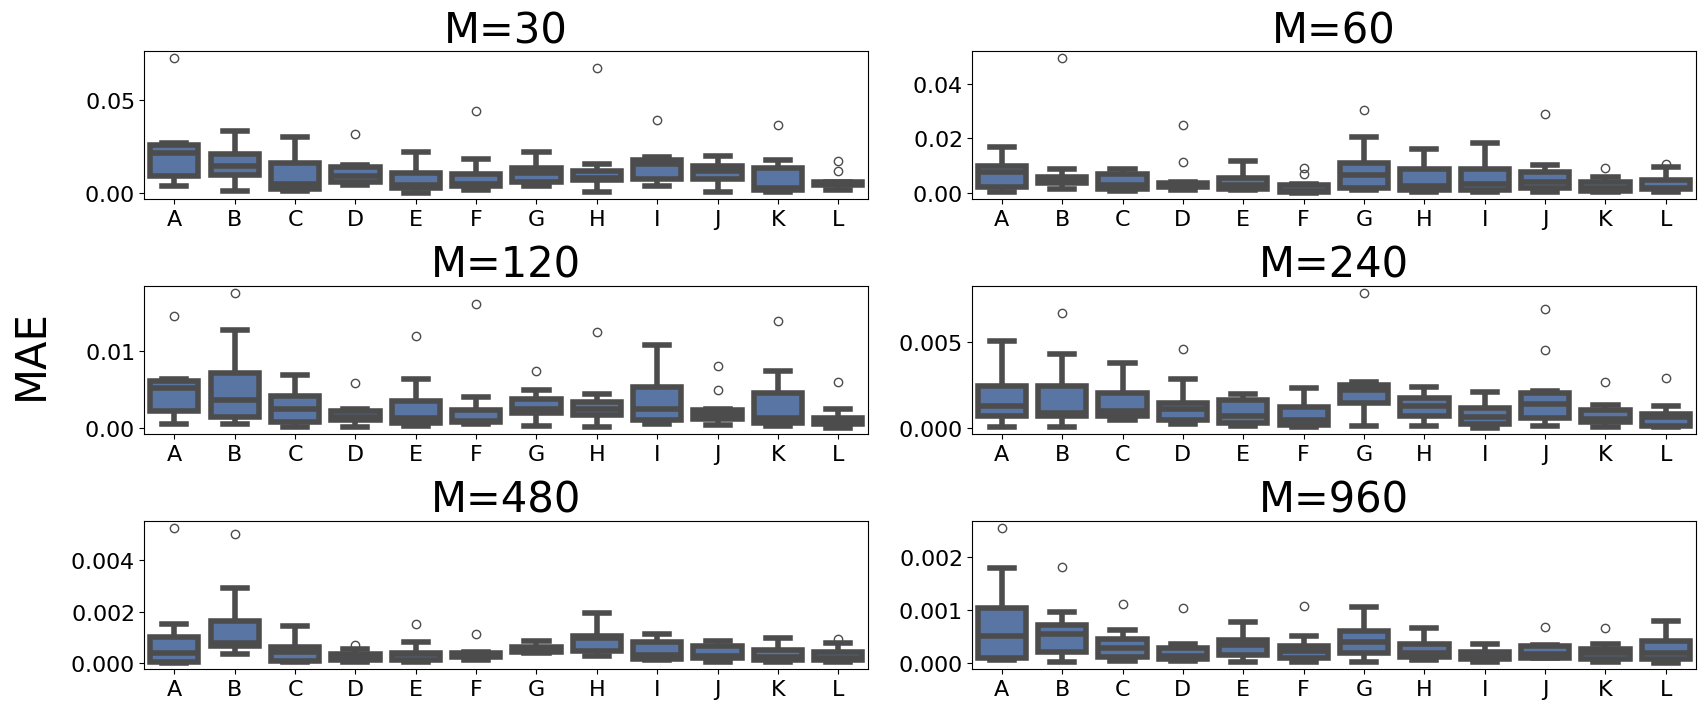

In [48]:
workloads = ["IRM", "PH"]
pairs = list(itertools.product(workloads, ks, thetas))
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"[:len(pairs)])

sns.set_palette("deep")
font_axes = 30
font_ticks = 16
line_width = 4
palette = sns.color_palette("deep", len(labels))
color_map = dict(zip(labels, palette))

mapping = {pk: lab for pk, lab in zip(pairs, labels)}
order = labels

df_plot = pd.concat([
    df_errors[["m", "theta", "tc", "k", "rel_error_irm"]]
        .rename(columns={"rel_error_irm": "abs_error"})
        .assign(workload="IRM"),
    df_errors[["m", "theta", "tc", "k", "rel_error_ph"]]
        .rename(columns={"rel_error_ph": "abs_error"})
        .assign(workload="PH"),
], ignore_index=True)

df_plot["method_param"] = list(zip(df_plot.workload, df_plot.k, df_plot.theta))
df_plot["label"] = df_plot["method_param"].map(mapping)
df_plot = df_plot.dropna(subset=["label", "abs_error"]).copy()

ms = [30, 60, 120, 240, 480, 960]
subplot_rows, subplot_cols = 3, 2
fig2, axes2 = plt.subplots(subplot_rows, subplot_cols, figsize=(18, 8),
                           sharex=False, sharey=False)
axes_flat = axes2.flatten()

for ax2, M in zip(axes_flat, ms):
    cell = df_plot[df_plot.m == M].copy()
    sns.boxplot(x='label', y='abs_error', data=cell, ax=ax2,
                linewidth=line_width, order=order)
    ax2.set_title(f"M={M}", fontsize=font_axes)
    ax2.tick_params(labelsize=font_ticks)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

fig2.text(0.025, 0.5, 'MAE', va='center', rotation='vertical',
          fontsize=font_axes)
plt.tight_layout(rect=[0.05, 0.05, 0.97, 0.95])
# plt.savefig("figures/clock_k2_mae.pdf", format='pdf')
plt.show()


In [15]:

ms = [30, 60, 120, 240, 480, 960]
n = 10000000
thetas = [0.8, 1.1]
records = []
errors = []
ks = [0, 1, 15]

for m in ms:
    taus = gen_taus(m * 1.5, 10, power=0.95)
    for a in thetas:
        lmb, trc_irm = gen_from_zipf(m, n, a)
        trc_he = gen_from_he(m, a, n)      

        for tc in taus:
            for k in ks:
                cc_c_irm_pred, cc_hr_irm_pred = clock_k_irm_linear(lmb, tc, K=k)
                if k == 0:
                    cc_hr_irm_sim = tg.sim_fifo(int(cc_c_irm_pred), trc_irm, raw=True)
                else:
                    cc_hr_irm_sim = tg.sim_clock(int(cc_c_irm_pred), trc_irm, raw=True, K=k)

                cc_c_he_pred, cc_hr_he_pred = clock_k_he_linear(lmb, tc, K=k)
                if k == 0:
                    cc_hr_he_sim = tg.sim_fifo(int(cc_c_he_pred), trc_he, raw=True)
                else:
                    cc_hr_he_sim = tg.sim_clock(int(cc_c_he_pred), trc_he, raw=True, K=k)

                records.append((m, a, tc, k, cc_c_irm_pred, cc_hr_irm_pred, cc_hr_irm_sim, cc_c_he_pred, cc_hr_he_pred, cc_hr_he_sim))
                errors.append((m, a, tc, k,
                               abs(cc_hr_irm_pred - cc_hr_irm_sim) / cc_hr_irm_sim,
                               abs(cc_hr_he_pred - cc_hr_he_sim) / cc_hr_he_sim))
df_records = pd.DataFrame(records, columns=["m", "theta", "tc", "k", "c_cc_irm_pred", "hr_cc_irm_pred", "hr_sim_irm", "c_cc_he_pred", "hr_cc_he_pred", "hr_sim_he"])
df_errors = pd.DataFrame(errors, columns=["m", "theta", "tc", "k", "rel_error_irm", "rel_error_he"])

In [16]:
df_records.to_pickle("ttl_clock_k2_records.pkl")
df_errors.to_pickle("ttl_clock_k2_errors.pkl")

df_records = pd.read_pickle("ttl_clock_k2_records.pkl")
df_errors = pd.read_pickle("ttl_clock_k2_errors.pkl")

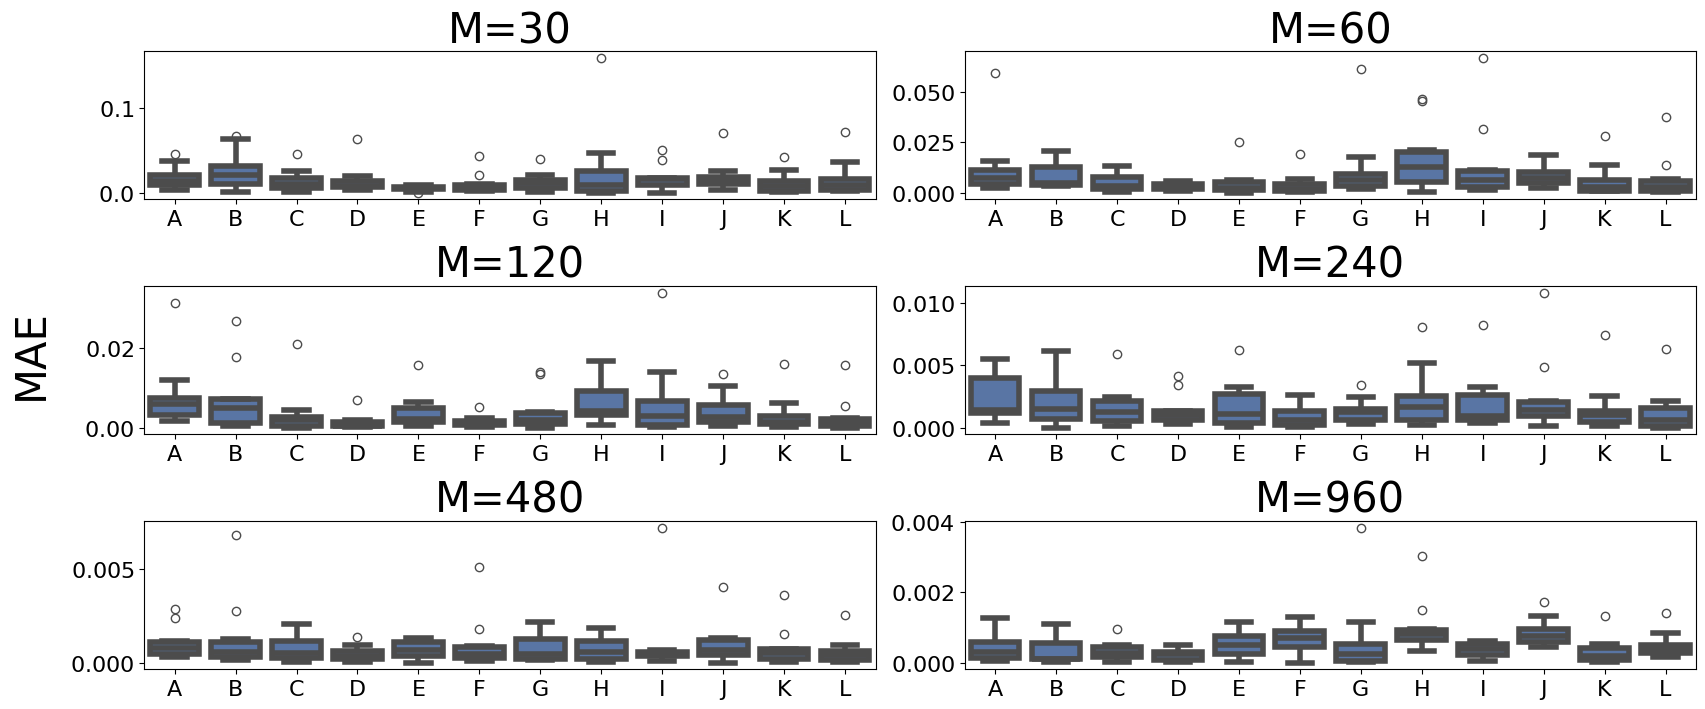

In [17]:
workloads = ["IRM", "HE"]
pairs = list(itertools.product(workloads, ks, thetas))
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"[:len(pairs)])

sns.set_palette("deep")
font_axes = 30
font_ticks = 16
line_width = 4
palette = sns.color_palette("deep", len(labels))
color_map = dict(zip(labels, palette))

mapping = {pk: lab for pk, lab in zip(pairs, labels)}
order = labels

df_plot = pd.concat([
    df_errors[["m", "theta", "tc", "k", "rel_error_irm"]]
        .rename(columns={"rel_error_irm": "abs_error"})
        .assign(workload="IRM"),
    df_errors[["m", "theta", "tc", "k", "rel_error_he"]]
        .rename(columns={"rel_error_he": "abs_error"})
        .assign(workload="HE"),
], ignore_index=True)

df_plot["method_param"] = list(zip(df_plot.workload, df_plot.k, df_plot.theta))
df_plot["label"] = df_plot["method_param"].map(mapping)
df_plot = df_plot.dropna(subset=["label", "abs_error"]).copy()

ms = [30, 60, 120, 240, 480, 960]
subplot_rows, subplot_cols = 3, 2
fig2, axes2 = plt.subplots(subplot_rows, subplot_cols, figsize=(18, 8),
                           sharex=False, sharey=False)
axes_flat = axes2.flatten()

for ax2, M in zip(axes_flat, ms):
    cell = df_plot[df_plot.m == M].copy()
    sns.boxplot(x='label', y='abs_error', data=cell, ax=ax2,
                linewidth=line_width, order=order)
    ax2.set_title(f"M={M}", fontsize=font_axes)
    ax2.tick_params(labelsize=font_ticks)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

fig2.text(0.025, 0.5, 'MAE', va='center', rotation='vertical',
          fontsize=font_axes)
plt.tight_layout(rect=[0.05, 0.05, 0.97, 0.95])
# plt.savefig("figures/clock_k2_mae.pdf", format='pdf')
plt.show()
